## Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config Inlinebackend.figure_format = 'svg'

from sklearn.metrics import r2_score as r2, mean_squared_error as mse, mean_absolute_error as mae
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

## Preprocessing functions

In [2]:
def reduction_memory(df: pd.DataFrame) -> pd.DataFrame:
    """function for reduction memory size"""
    
    df_c = df.copy()
    
    for column in df_c.columns:
    
        series = df_c[column]
        
        if series.dtype == 'float64':
            if (series != series.astype('float32')).sum() == 0:
                df_c[column] = series.astype('float32')
        elif series.dtype == 'int64':
            if (series != series.astype('int8')).sum() == 0:
                df_c[column] = series.astype('int8')
            elif (series != series.astype('int16')).sum() == 0:
                df_c[column] = series.astype('int16')
            elif (series != series.astype('int32')).sum() == 0:
                df_c[column] = series.astype('int32')
                
    return df_c

In [3]:
def val_diff(df: pd.DataFrame, val: str) -> pd.Series:
    """creates new column: 'Val_Diff_1' - Value Difference period = 1"""
    
    df = df.copy()
    
    df['Val_Diff_1'] = 0
    df['Val_Diff_1'][1:] = df[val].diff(1)[1:]
    
    return df

In [4]:
def recover_data(df:pd.DataFrame, column:str) -> pd.DataFrame:
    
    df = df.copy()
    
    null = df[df[column].isna()]
    index_list = null.index
    index_name = index_list.name

    df_idx = df.reset_index()

    for i in index_list:
        index_null = df_idx[df_idx[index_name] == i].index

        neighbors = df_idx.loc[index_null+1 | index_null-1]

        mean_vals = neighbors[column].mean()
        df.loc[i, column] = mean_vals
        
    return df

## Path to files

In [5]:
# PATH_TO_BRENT = '../input/ml-in-business/my_BRENT2019.csv'
# PATH_TO_RUB_USD = '../input/ml-in-business/RC_F01_09_2010_T01_09_2019.xlsx'
# PATH_TO_RUB_EURO = '../input/ml-in-business/R_E01_09_2010_T01_09_2019.xlsx'

PATH_TO_BRENT = 'my_BRENT2019.csv'
PATH_TO_RUB_USD = 'RC_F01_09_2010_T01_09_2019.xlsx'
PATH_TO_RUB_EURO = 'R_E01_09_2010_T01_09_2019.xlsx'

# 1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями

# 2. сделайте ее перерасчет (ресемплинг) в представление по неделям.

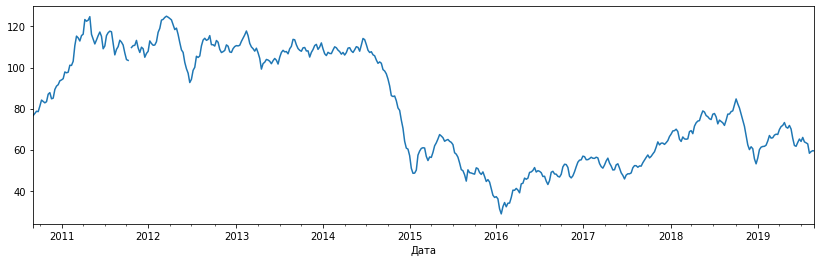

In [6]:
# read data
df_brent19 = pd.read_csv(PATH_TO_BRENT, index_col=0, parse_dates=[0])

# resample
df_brent19 = df_brent19.resample('W').mean()

# view
df_brent19['Значение'].plot(figsize=(14,4))

##### В недельных графиках обнаружились разрывы по обоим валютам<br>
восстановим данные при помощи усреднения значений соседних строк, добавим в датафрейм разности таргета и просмотрим результат

In [7]:
def plots(ser1: pd.Series, ser2: pd.Series):
    """draws two graphs horizontally"""
    
    fig, ax = plt.subplots(ncols=2)

    ax1, ax2 = ax

    ax1.plot(ser1)

    ax2.plot(ser2)

    fig.set_size_inches(18, 4)
    plt.subplots_adjust(wspace=0.1)

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,Val_Diff_1
Дата,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,0.000000,0.000000
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.0,0.166667,1.057333
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.000000,0.0,0.000000,1.020000
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.000000,0.0,0.000000,-0.175000
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.000000,0.0,0.000000,2.693333


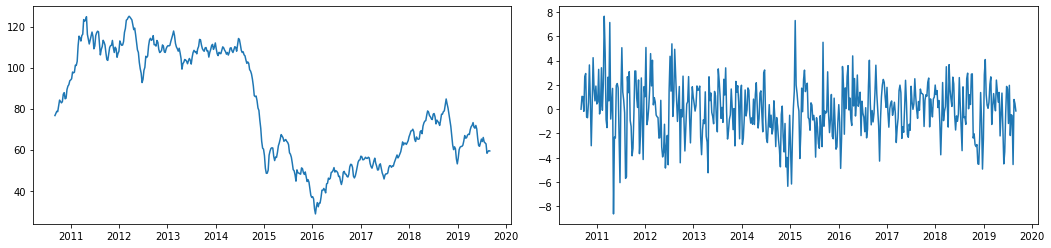

In [8]:
# recover data
df_brent19 = recover_data(df=df_brent19, column='Значение')

# difference
df_brent19 = val_diff(df=df_brent19, val='Значение')

# viewing
    # plot
plots(df_brent19['Значение'], df_brent19['Val_Diff_1'])
    # dataset
df_brent19[:5]

# 2. Добавьте первые разности по стоимости доллара и евро к рублю

##### RUB-USD

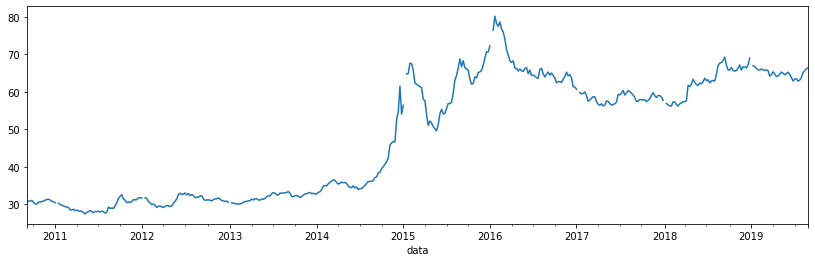

In [9]:
# read data and del excess columns
df_rub_usd19 = pd.read_excel(PATH_TO_RUB_USD, index_col='data', parse_dates=['data'])
df_rub_usd19 = df_rub_usd19.drop(['nominal', 'cdx'], axis=1)

#resampling
df_rub_usd19 = df_rub_usd19.resample('W').mean()

# view
df_rub_usd19['curs'].plot(figsize=(14,4))

,curs,Val_Diff_1
data,,
2010-09-05,30.76125,0.00000
2010-09-12,30.79402,0.03277
2010-09-19,30.84672,0.05270
2010-09-26,30.99920,0.15248
2010-10-03,30.52764,-0.47156


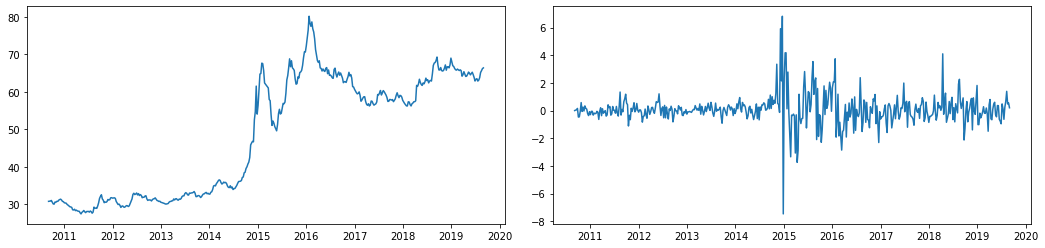

In [10]:
# recover data
df_rub_usd19 = recover_data(df=df_rub_usd19, column='curs')

# difference
df_rub_usd19 = val_diff(df=df_rub_usd19, val='curs')

# viewing
    # plot
plots(df_rub_usd19['curs'], df_rub_usd19['Val_Diff_1'])
    # dataset
df_rub_usd19[:5]

##### RUB-EURO

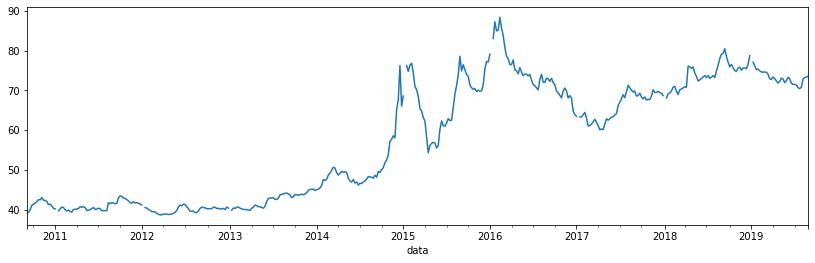

In [11]:
# read data and del excess columns
df_rub_euro19 = pd.read_excel(PATH_TO_RUB_EURO, index_col='data', parse_dates=['data'])
df_rub_euro19 = df_rub_euro19.drop(['nominal', 'cdx'], axis=1)

#resampling
df_rub_euro19 = df_rub_euro19.resample('W').mean()

# view
df_rub_euro19['curs'].plot(figsize=(14,4))

,curs,Val_Diff_1
data,,
2010-09-05,39.204675,0.000000
2010-09-12,39.293360,0.088685
2010-09-19,39.977740,0.684380
2010-09-26,41.042640,1.064900
2010-10-03,41.351660,0.309020


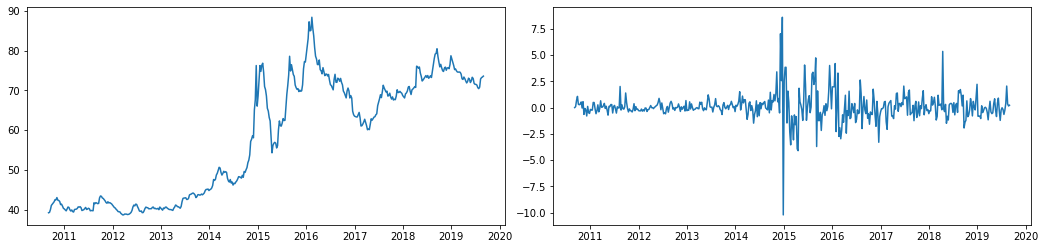

In [12]:
# recover data
df_rub_euro19 = recover_data(df=df_rub_euro19, column='curs')

# difference
df_rub_euro19 = val_diff(df=df_rub_euro19, val='curs')

# viewing
    # plot
plots(df_rub_euro19['curs'], df_rub_euro19['Val_Diff_1'])
    # dataset
df_rub_euro19[:5]

##### Объединим данные

In [13]:
df_brent19[['USD', 'USD_diff_1']] = df_rub_usd19[['curs', 'Val_Diff_1']]
df_brent19[['EURO', 'EURO_diff_1']] = df_rub_euro19[['curs', 'Val_Diff_1']]
df_brent19[:5]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,Val_Diff_1,USD,USD_diff_1,EURO,EURO_diff_1
Дата,,,,,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,0.000000,0.000000,30.76125,0.00000,39.204675,0.000000
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.0,0.166667,1.057333,30.79402,0.03277,39.293360,0.088685
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.000000,0.0,0.000000,1.020000,30.84672,0.05270,39.977740,0.684380
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.000000,0.0,0.000000,-0.175000,30.99920,0.15248,41.042640,1.064900
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.000000,0.0,0.000000,2.693333,30.52764,-0.47156,41.351660,0.309020


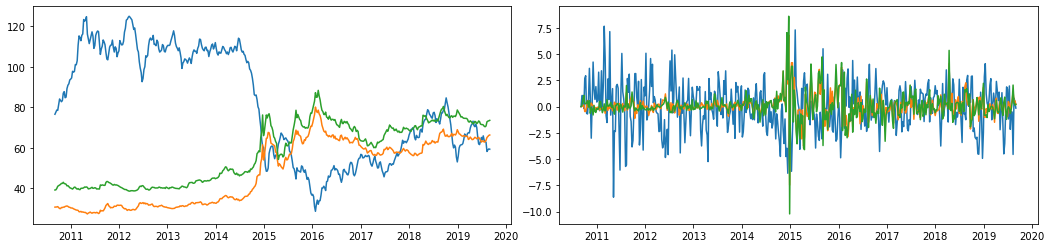

In [14]:
plots(df_brent19[['Значение', 'USD', 'EURO']], df_brent19[['Val_Diff_1', 'USD_diff_1', 'EURO_diff_1']])

In [15]:
date_nan = df_brent19['year'].isna()
index_date = df_brent19[date_nan].index

df_brent19.loc[date_nan, 'year'] = index_date.year
df_brent19.loc[date_nan, 'month'] = index_date.month

## 4. Постройте модель предсказания 1-й точки от текущей (h=1).

In [17]:
def train_test_split(df, target, h):
    """function for spliting data"""
    
    X_train = df[:-h].drop(target, axis=1)
    X_test = df[-h:].drop(target, axis=1)
    
    y_train = df[:-h][target]
    y_test = df[-h:][target]
    
    return X_train, X_test, y_train, y_test

In [29]:
df_brent19.columns

Index(['Значение', 'year', 'month', 'dayofmonth', 'quarter', 'dayofyear',
       'weekofyear', 'dayofweek', 'is_holiday', 'is_prev_holiday',
       'is_next_holiday', 'Val_Diff_1', 'USD', 'USD_diff_1', 'EURO',
       'EURO_diff_1'],
      dtype='object')

In [68]:
# Select features
columns = ['year', 'month', 'Val_Diff_1', 'USD', 'USD_diff_1', 'EURO', 'EURO_diff_1', 
           'Значение']
df_brent19_to_split = df_brent19[columns]

# Spliting data
X_train, X_test, y_train, y_test = train_test_split(df=df_brent19_to_split, 
                                                    target='Значение', 
                                                    h=1)
# fiting model
model_gbr = GradientBoostingRegressor(max_depth=1, n_estimators=17, random_state=42)
model_gbr.fit(X_train, y_train)

# predicting
y_train_pred = model_gbr.predict(X_train)
y_test_pred = model_gbr.predict(X_test)

print(f'mse = {mse(y_true=y_test, y_pred=y_test_pred)}')
print(f'mae = {mae(y_true=y_test, y_pred=y_test_pred)}')

mse = 4.772618979989521
mae = 2.184632458787867


## 5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

In [60]:
# Select features
columns = ['USD', 'EURO', 
           'Значение']
df_brent19_to_split = df_brent19[columns]

# Spliting data
X_train, X_test, y_train, y_test = train_test_split(df=df_brent19_to_split, 
                                                    target='Значение', 
                                                    h=1)
# fiting model
model_gbr = GradientBoostingRegressor(max_depth=1, n_estimators=17, random_state=42)
model_gbr.fit(X_train, y_train)

# predicting
y_train_pred = model_gbr.predict(X_train)
y_test_pred = model_gbr.predict(X_test)

print(f'mse = {mse(y_true=y_test, y_pred=y_test_pred)}')
print(f'mae = {mae(y_true=y_test, y_pred=y_test_pred)}')

mse = 4.772618979989521
mae = 2.184632458787867


##### Прямое предсказание не отливается от предсказания с diff = 1